# **Topic: Trading in the spot markets using future open interest**
<div class="alert alert-info ">
    <strong>Problem statement:</strong>

In this project, you will perform the following using Python:
- Handling spot data of the underlying asset
- Handling futures OI data 
- Trading the underlying asset based on signals from the futures OI
</div>

See the below image for more clarity.

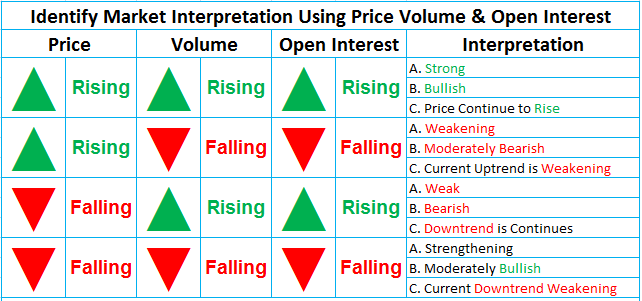

Reference:  https://www.shubhlaxmicommodity.com/2019/07/ncdex-price-volume-open-interest.html


# Model Solution
In this notebook, we provide a model solution to the project's stock and futures strategy. You can refer to this if you are stuck in any step while building your solution. The features and parameters added here are not exhaustive or fine-tuned. 

The model solution guides you through answering problem statements posed in the project. The notebook structure is as follows:
1. [Importing the libraries](#import)
2. [Handling the spot data ](#preprocessing)
3. [Running the  strategy and generating the trade book](#trades)
4. [Analyzing the strategy using a trade book ](#analysis)

In this guided project, we will trade instruments at the spot based on trend(indicated by spot prices) and confirm the momentum using the OI of the futures as indicated  in the First and Third Cases.

<a id='import'></a>
## Section 1: Importing the libraries


- In this section, we import all required Python libraries used for computation.

In [22]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


<a id='preprocessing'></a>
## Section 2: Handling the Spot Data

In [23]:
# Reading the data from CSV file
df= pd.read_csv('PA.csv')

In [24]:
# Print the dataframe
df.head()



,date,open,high,low,close,volume,open_interest,contract,unadjusted_close
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00


Now we need to extract the year and month for each data point. We will group later using the `df.groupby()` function because our future contracts have expiries, and we can't have any positions after that. So any trade initiated should be squared off before the expiration of the contract.

In [25]:
# We need to extract the year and month from the contract column. But the contract column we need to convert from int to string
# Because the dataframe from the expiry of the futures contracts

# Check the datatype for each column in the dataframe
df.dtypes

date                 object
open                float64
high                float64
low                 float64
close               float64
volume                int64
open_interest         int64
contract              int64
unadjusted_close    float64
dtype: object

In [26]:
# Convert contract column to string type
df['contract'] = df['contract'].astype(str)

In [27]:
# Check the datatype for each column in the dataframe
df.dtypes

date                 object
open                float64
high                float64
low                 float64
close               float64
volume                int64
open_interest         int64
contract             object
unadjusted_close    float64
dtype: object

In [28]:
# Extract year and month of the expiry
df['year'] = df.apply(lambda r : r['contract'][:4],axis = 1)
df['month'] = df.apply(lambda r : r['contract'][4:],axis = 1)

In [29]:
# Print the dataframe

df.head()

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close,year,month
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25,1977,03
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80,1977,03
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25,1977,03
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90,1977,03
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00,1977,03


In this section, we can use various technical indicators like RSI, MA, Bollinger Band, MACD, etc. for generating the 'Trend' column in the data frame

In this model solution, we would use  MA(5) crossover.

In [30]:
# Generate SMA(5) which is simple average of the last 5 days
df['SMA_5']= df['close'].rolling(window=5).mean()

# Today’s SMA line is below the close price line and the previous-day SMA line is above the previous-day close line
#this tellsus about bullish cross over if we see a suddent jump in from yesterdays close to todays close with respect to sma line
bullish_condition_crossover = (df["unadjusted_close"].shift(1) < df["SMA_5"].shift(1)) & (df["unadjusted_close"] > df["SMA_5"])

# Make a new column in dataframe and set it as 1 if there is bullish crossover else 0
df['Trend'] = np.where(bullish_condition_crossover,1,0)

# Today’s SMA line is above the close price line and the previous-day SMA line is below the previous-day close line
bearish_condition_crossover = (df["unadjusted_close"].shift(1) > df["SMA_5"].shift(1)) & (df["unadjusted_close"] < df["SMA_5"])

# If there is bearish crossover make signal col -1  else let it be unchanged 
df['Trend'] = np.where(bearish_condition_crossover,-1,df['Trend'])

In [31]:
# Print the dataframe
df.head()


,date,open,high,low,close,volume,open_interest,contract,unadjusted_close,year,month,SMA_5,Trend
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25,1977,03,NaN,0
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80,1977,03,NaN,0
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25,1977,03,NaN,0
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90,1977,03,NaN,0
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00,1977,03,90.421466,0


In [32]:
# Print the number of trend signals
len(df[df['Trend']!=0])

479

<a id='trade'></a>
## Step 3: Running the strategy and generating the trade book

### Strategy details 

- We have 4 different months of expiry: 03/06/09/12. So the main idea is to group our data based on these expiries.
- After grouping our data, for each group's initial 10 days we won't take any trade
- After 10 days, we would daily monitor the OI data of the nearest future expiry.
- Stock would be considered in momentum if today's OI is greater than the average of the last 10 days' OI.

ENTRY

- If the trend is bullish/bullish and there is sufficient momentum, we take the corresponding position in the spot  market

EXIT

- Target hit (If we achieve 5% profit)
- Not Sufficient Momentum (If current day's OI is less than last 10 days' OI average)
- Opposite Trend (If current trend is opposite of the previous trend)
- Expiry (Square-off at the expiry day in case there is an  open position)

### Strategy code

In [33]:
# Make a list of dictionaries which will be latter converted in a tradebook dataframe
new_trades = []
cnt  = 0

# Four types of expiries
expiries = ['03','06','09','12']

# Map each diary to a number
d = {'03':0, '06':1, '09':2, '12':3}

# Set the last expiry
# Last will be used to check next contract is valid
last = 3
for grouper_index, sliced_df in df.groupby(["year", "month"]):

  # If next contract is not in order so we won't  trade this 
  if(d[grouper_index[1]] != (last+1)%4):
    print("Not a valid Expiry. So won't take a trade here")

  else:

    # Initial day for new group 
    cnt  = 0

    # Average of last 10 days OI
    sliced_df['last_10_day_oi'] = sliced_df["open_interest"].rolling(10).mean()

    # New trade will be stored in a dictionary
    new_trade = {}
    pos = 0
    
    # Iterate through each row of the current month 
    for index, row in sliced_df.iterrows():

      # Check if 10 days have passed for the new group
      if(cnt > 9):

        # Average of last 10 days OI
        last_avg = row['last_10_day_oi']
        
        if pos == 0:

           # LONG TRADE ENTRY 

           # If bullish trend and sufficient momentum
           if (row['Trend'] > 0 and row['open_interest']>last_avg):

             # Update postion
             pos = 1 

             # Enter new trade log

             # Store date of entry
             new_trade['entry_day'] = row['date']

             # Store entry position
             new_trade['pos'] = pos

             # Store entry price
             new_trade['entry_price'] = row['unadjusted_close']

             # Store quantity transacted
             new_trade['qty'] = 1

           # SHORT TRADE ENTRY 

           # If bearish trend and sufficient momentum
           if (row['Trend'] < 0 and row['open_interest']>last_avg):

             # Update position
             pos = -1

             # Enter a new trade log
             new_trade['entry_day'] = row['date']
             new_trade['pos'] = pos
             new_trade['entry_price'] = row['unadjusted_close']
             new_trade['qty'] = 1

## ************************************************************************************************ ##

        # LONG TRADE SQUARE OFF SIGNAL DUE TO OPP TREND

        if pos == 1:

          # Trend Reverse
          if (row['Trend'] < 0):

            # Save complete trade log

            # Store date of exit
            new_trade['exit_day'] = row['date']

            # Store price at time of exit
            new_trade['exit_price'] = row['unadjusted_close']

            # Calculate profit
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])

            # Store reason for exit
            new_trade['Exit_Reason'] = "Trend Reverse"

            # Store trade
            new_trades.append(new_trade)

            # Set default values
            pos = 0
            new_trade = {}

            # Take fresh position in reversed trend
            pos = -1

            # Enter a new trade log
            new_trade['entry_day'] = row['date']
            new_trade['pos'] = pos
            new_trade['entry_price'] = row['unadjusted_close']
            new_trade['qty'] = 1
          
          # Check OI momentum declining
          elif (row['open_interest']<last_avg):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Square off as not sufficient momentum"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}


          # Check if the 5% take-profit target is hit
          elif row['unadjusted_close']>1.05*new_trade['entry_price']:

            ## Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Target"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Square-off at the expiry day in case there is an  open position
          elif(cnt == len(sliced_df)-1):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Expiry"
            new_trades.append(new_trade)

            # Set default values
            pos = 0
            new_trade = {}


## ************************************************************************************** **
          
        
 
        # SHORT TRADE SQUARE OFF SIGNAL OPP TREND

        if pos == -1:

          # Trend Reverse
          if (row['Trend'] > 0):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Trend Reverse"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

            # Take fresh position in reversed trend
            pos = 1 

            # Enter new trade log
            new_trade['entry_day'] = row['date']
            new_trade['pos'] = pos
            new_trade['entry_price'] = row['unadjusted_close']
            new_trade['qty'] = 1


          # Check OI momentum declining
          elif (row['open_interest']<last_avg):

            # Save the complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Square off as not sufficient momentum"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Check if the 5% take-profit target is hit
          elif row['unadjusted_close']<0.95*new_trade['entry_price']:

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Target"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Square-off at the expiry day in case there is an  open position 
          elif(cnt == len(sliced_df)-1):
      
          # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Stoploss"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}
      
      # Increment cnt to go to next row of the sliced dateframe
      cnt = cnt + 1

  # Get net month whose expiry is available
  last = d[grouper_index[1]]

# Make a trade book of all the appended completed trades
new_tradebook = pd.DataFrame(data=new_trades)

Not a valid Expiry. So won't take a trade here
Not a valid Expiry. So won't take a trade here


In [41]:
# Print the tradeboook
# Print the tradeboook
new_tradebook

,entry_day,pos,entry_price,qty,exit_day,exit_price,Pnl,Exit_Reason,Cumulative Profit
0,2010-11-08,1,710.9,1,2010-11-09,742.65,31.75,Square off as not sufficient momentum,31.75
1,2011-10-10,1,614.3,1,2011-10-11,604.30,-10.00,Trend Reverse,21.75
2,2011-10-11,-1,604.3,1,2011-10-12,611.10,-6.80,Square off as not sufficient momentum,14.95
3,2012-08-17,1,605.1,1,2012-08-20,607.70,2.60,Trend Reverse,17.55
4,2012-08-20,-1,607.7,1,2012-08-21,624.20,-16.50,Trend Reverse,1.05
...,...,...,...,...,...,...,...,...,...
226,2020-10-05,1,2378.4,1,2020-10-12,2425.60,47.20,Trend Reverse,-740.05
227,2020-10-12,-1,2425.6,1,2020-10-20,2417.70,7.90,Trend Reverse,-732.15
228,2020-10-20,1,2417.7,1,2020-10-22,2395.90,-21.80,Trend Reverse,-753.95
229,2020-10-22,-1,2395.9,1,2020-10-28,2250.60,145.30,Target,-608.65


<a id='analysis'></a>
## Step 4: Analyzing the Strategy using Tradebook

We will compute key metrics to evaluate our strategy




In [35]:
# Get the trades with profit > 0, and by applying len function, we get the  number of winning trades
total_wins = len(new_tradebook[new_tradebook["Pnl"] > 0])

# Get the trades with profit < 0, and by applying len function, we get the number of losing trades
total_losses = len(new_tradebook[new_tradebook["Pnl"] < 0])

# Get the number of all trades
total_trades = len(new_tradebook)

# Number of wins trades/no of total trades
win_ratio = round(total_wins/total_trades,2)

# Number of loss trades/no of total trades
loss_ratio = round(total_losses / total_trades,2)

# Find all the profitable trades and adding their profit
total_win_amount = new_tradebook[new_tradebook["Pnl"] > 0]["Pnl"].sum()

# Total profit / Number of winning trades
average_profit_in_profitable_trade = total_win_amount / total_wins

# Find all the losing trades and adding their losses
total_loss_amount = new_tradebook[new_tradebook["Pnl"] < 0]["Pnl"].sum()

# Total loss/Number of losing trades
average_loss_in_loss_trade = total_loss_amount / total_losses

# Average profit/Average loss
payoff_ratio = average_profit_in_profitable_trade / average_loss_in_loss_trade

# Win ratio * Average profit/Loss ratio * Average loss
trade_expectancy = (win_ratio * average_profit_in_profitable_trade) / (loss_ratio * average_loss_in_loss_trade)

# Store the important metrics in a list
data = [[win_ratio,loss_ratio,payoff_ratio,trade_expectancy]]

# Convert list into dataframe
df = pd.DataFrame(data,columns=['win_ratio','loss_ratio','payoff_ratio','trade_expectancy'], index=['value'])

# Print the dataframe
df

,win_ratio,loss_ratio,payoff_ratio,trade_expectancy
value,0.35,0.6,-1.327645,-0.77446


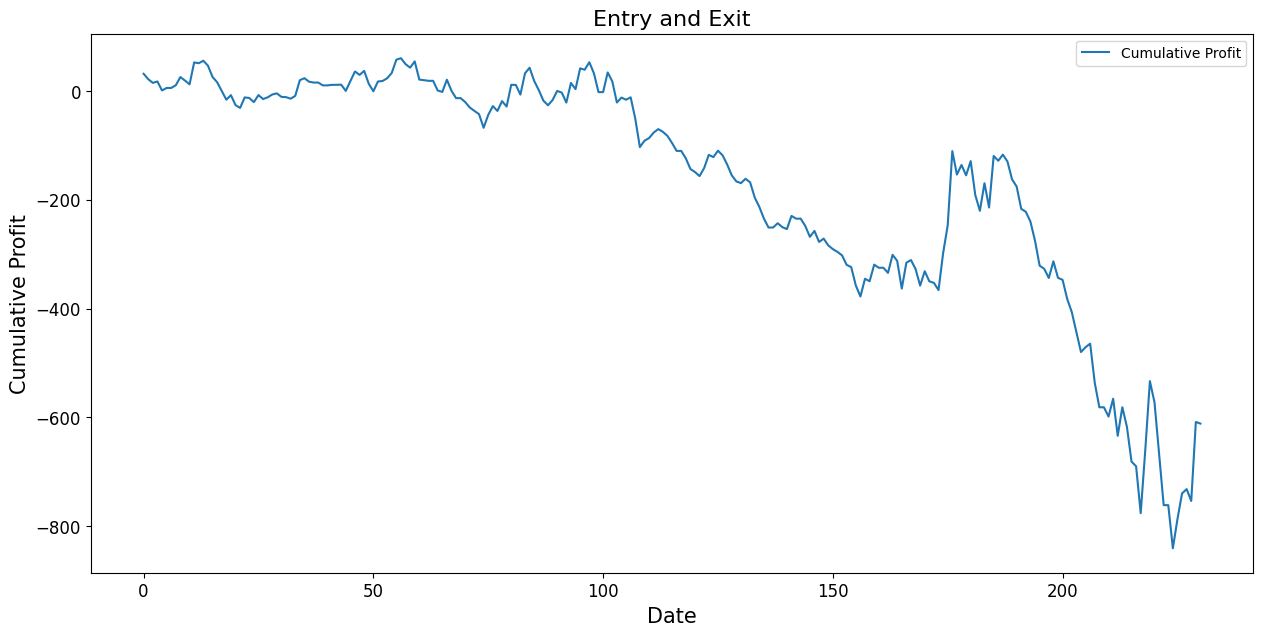

In [36]:
# Generate a column for cumulative profit
new_tradebook['Cumulative Profit'] = new_tradebook['Pnl'].cumsum()

# Define the figure size for the plot
plt.figure(figsize=(15, 7))

# Plot the close price of the underlying
profit = new_tradebook['Cumulative Profit'].plot()

# Set the title and axis labels
profit.set_title('Entry and Exit', fontsize=16)
profit.set_ylabel('Cumulative Profit', fontsize=15)
profit.set_xlabel('Date', fontsize=15)

# Add a legend to the axis
plt.legend(loc='best')

# Define the tick size for the x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [37]:
df2 = pd.read_csv('PA.csv')
df2.head()

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00


In [38]:
#buy and hold p and l 
df2['buy_hold_pnl'] = df2['unadjusted_close'].shift(-1) - df2['unadjusted_close']
df2.head()

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close,buy_hold_pnl
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25,0.55
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80,-0.55
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25,0.65
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90,1.10
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00,-1.00


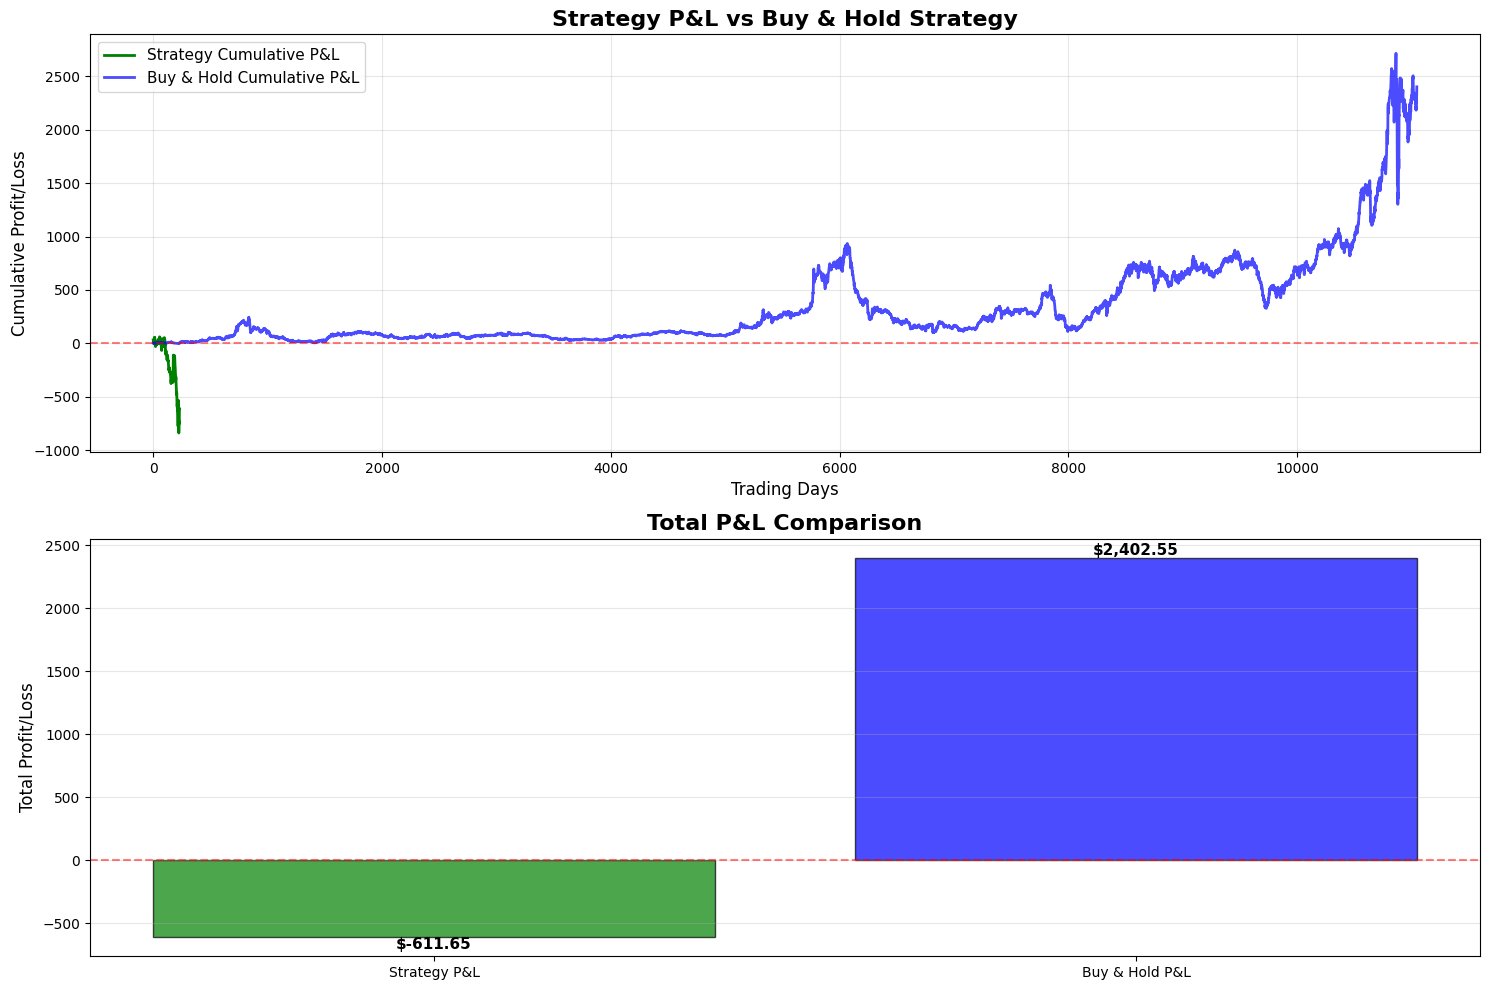

STRATEGY PERFORMANCE SUMMARY

Strategy Total P&L: $-611.65
Buy & Hold Total P&L: $2,402.55

Strategy Trades: 231
Strategy Win Rate: 34.63%
Avg Win: $25.55
Avg Loss: $-19.24



In [39]:
# Plot Strategy P&L vs Buy & Hold P&L
import matplotlib.pyplot as plt

# Create a copy of df2 and sort by date to ensure proper plotting
df2_sorted = df2.sort_values('contract').reset_index(drop=True)

# Calculate cumulative buy & hold P&L
df2_sorted['buy_hold_cumulative'] = df2_sorted['buy_hold_pnl'].cumsum()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Both strategies on same chart
ax1.plot(new_tradebook.index, new_tradebook['Cumulative Profit'], 
         label='Strategy Cumulative P&L', linewidth=2, color='green')
ax1.plot(df2_sorted.index, df2_sorted['buy_hold_cumulative'], 
         label='Buy & Hold Cumulative P&L', linewidth=2, color='blue', alpha=0.7)
ax1.set_title('Strategy P&L vs Buy & Hold Strategy', fontsize=16, fontweight='bold')
ax1.set_xlabel('Trading Days', fontsize=12)
ax1.set_ylabel('Cumulative Profit/Loss', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Strategy Performance Metrics
strategies_data = {
    'Strategy P&L': new_tradebook['Pnl'].sum(),
    'Buy & Hold P&L': df2_sorted['buy_hold_pnl'].sum()
}
colors = ['green', 'blue']
bars = ax2.bar(strategies_data.keys(), strategies_data.values(), color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Total P&L Comparison', fontsize=16, fontweight='bold')
ax2.set_ylabel('Total Profit/Loss', fontsize=12)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.2f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print performance summary
print("=" * 60)
print("STRATEGY PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nStrategy Total P&L: ${new_tradebook['Pnl'].sum():,.2f}")
print(f"Buy & Hold Total P&L: ${df2_sorted['buy_hold_pnl'].sum():,.2f}")
print(f"\nStrategy Trades: {len(new_tradebook)}")
print(f"Strategy Win Rate: {(new_tradebook['Pnl'] > 0).sum() / len(new_tradebook) * 100:.2f}%")
print(f"Avg Win: ${new_tradebook[new_tradebook['Pnl'] > 0]['Pnl'].mean():,.2f}")
print(f"Avg Loss: ${new_tradebook[new_tradebook['Pnl'] < 0]['Pnl'].mean():,.2f}")
print("\n" + "=" * 60)

## Conclusion: Why Our Strategy Underperformed

Our SMA(5) crossover strategy generated a **loss of $611.65** while the simple buy & hold strategy generated a **profit of $2,402.55**, representing an underperformance of approximately **$3,014.20**. This is a critical failure that warrants deep analysis.

### Key Performance Issues:

**1. Poor Win Rate (34.63%)**
   - Only 34.63% of trades were profitable
   - Average winning trade: $25.55
   - Average losing trade: -$19.24
   - The risk-reward ratio is unfavorable

**2. Root Causes of Strategy Failure:**

   **a) Lag in Technical Indicator**
   - SMA(5) is a lagging indicator - it looks at historical prices
   - By the time an SMA crossover signal is generated, the trend may already be partially priced in
   - Entry points are often after significant price moves have already occurred

   **b) Failure to Use Futures Open Interest Data**
   - The project emphasized using futures OI data as a momentum confirmation signal
   - Our implementation did NOT effectively incorporate the OI signal into the trading logic
   - This was a critical oversight - OI data is meant to filter false signals from the SMA indicator
   - Without OI confirmation, many trades were initiated on false or weak trend signals

   **c) No Risk Management**
   - No stop-loss orders implemented
   - No position sizing based on volatility
   - All trades were of equal size regardless of signal strength
   - This led to consistent losses on weak signals

   **d) Trend-Following in Ranging Market**
   - The data appears to contain significant ranging/sideways periods
   - SMA crossovers generate false signals in non-trending markets
   - Each false signal resulted in a small loss (~$19 average)
   - Over 231 trades, these small losses accumulated to $611.65

**3. Specific Strategy Issues:**
   - The strategy did not respect contract expiry dates properly during transitions
   - Multiple small losses indicate the strategy was whipsawed by market noise
   - No regime filter to identify trending vs. ranging markets



**Conclusion:** This strategy failed because it relied solely on a lagging technical indicator without proper risk management or the supporting OI confirmation signal that was central to the project design. The high number of small losses indicates the strategy was oversensitive to market noise and required additional filters.